# Visualize Multiple VRP Solutions

**Usage**  
1. Set `nodes_filepath` and `solution_routes_filepaths` in the **Inputs** cell.  
2. Run all cells.  
3. The notebook will render one figure **per solution** (no seaborn). Each route uses a different color and the legend shows the `vehicle_name`. Distances are labeled along each edge (km).  
4. Titles include the solution file path so you can compare runs (GA / ACO / PSO) side by side.


In [1]:
# === Inputs ===
# Path to your nodes CSV and a list of solution_routes.json files to compare
nodes_filepath = "Problems/vrp_nodes.csv"
solution_routes_filepaths = [
    "results/ga_cx_inversion/solution_routes.json",
    "results/aco/solution_routes.json",
    "results/pso/solution_routes.json",
]

# Label format: False -> show full path in title; True -> use just the basename
use_basename_in_title = False


In [2]:
import json
import math
import os
from typing import Dict, List, Tuple

import pandas as pd
import matplotlib.pyplot as plt

# --- Haversine distance in kilometers ---
EARTH_R = 6371008.8  # meters
def haversine_km(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = p2 - p1
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return (2 * EARTH_R * math.atan2(math.sqrt(a), math.sqrt(1 - a))) / 1000.0

def load_nodes(nodes_csv: str):
    df = pd.read_csv(nodes_csv)
    if not set(["id","lat","lon"]).issubset(df.columns):
        raise ValueError("nodes CSV must have columns: id, lat, lon")
    df = df.sort_values("id").reset_index(drop=True)
    # ensure depot id==0 exists
    if int(df.loc[0,"id"]) != 0:
        raise ValueError("Depot (id==0) must be first row; reindex your CSV.")
    # id -> (lat, lon)
    coords = {int(row.id):(float(row.lat), float(row.lon)) for row in df.itertuples(index=False)}
    return df, coords

def load_solution(path: str) -> Dict:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if "routes" not in data:
        raise ValueError(f"{path} must contain a top-level 'routes' list.")
    return data

def title_from_path(path: str, use_basename: bool) -> str:
    return os.path.basename(path) if use_basename else path


In [3]:
def plot_solution(nodes_df, coords, solution: Dict, title: str):
    fig, ax = plt.subplots(figsize=(9, 9))

    # Plot all nodes
    xs = nodes_df["lon"].astype(float).values
    ys = nodes_df["lat"].astype(float).values
    ax.scatter(xs, ys, s=30, zorder=3)
    for _, r in nodes_df.iterrows():
        ax.text(float(r["lon"]) + 0.0015, float(r["lat"]) + 0.0015, str(int(r["id"])),
                fontsize=8, ha="left", va="bottom", zorder=4)

    # Emphasize depot
    depot_lon = float(nodes_df.loc[0, "lon"])
    depot_lat = float(nodes_df.loc[0, "lat"])
    ax.scatter([depot_lon], [depot_lat], s=120, marker="s", zorder=5)

    # Draw routes
    for route in solution["routes"]:
        stops = route.get("stops_by_id")
        name = route.get("vehicle_name", f"veh-{route.get('vehicle_id','?')}")
        if not stops or len(stops) < 2:
            continue

        # Build polyline lon/lat
        line_lon = []
        line_lat = []
        for nid in stops:
            lat, lon = coords[int(nid)]
            line_lon.append(lon)
            line_lat.append(lat)

        # plot line
        ax.plot(line_lon, line_lat, linewidth=2, label=name, zorder=2)

        # Add arrows to show direction
        for i in range(len(stops) - 1):
            start_lon, start_lat = line_lon[i], line_lat[i]
            end_lon, end_lat = line_lon[i + 1], line_lat[i + 1]

            # Add arrow at the middle of the segment
            mid_lon = (start_lon + end_lon) / 2
            mid_lat = (start_lat + end_lat) / 2

            ax.annotate('', xy=(end_lon, end_lat), xytext=(mid_lon, mid_lat),
                        arrowprops=dict(arrowstyle='->', color='black',
                                        lw=1, alpha=0.7))

        # annotate distances on each edge midpoint
        for a, b in zip(stops[:-1], stops[1:]):
            (lat1, lon1) = coords[int(a)]
            (lat2, lon2) = coords[int(b)]
            d_km = haversine_km(lat1, lon1, lat2, lon2)
            mx = (lon1 + lon2) / 2.0
            my = (lat1 + lat2) / 2.0
            ax.text(mx, my, f"{d_km:.2f} km", fontsize=7,
                    ha="center", va="center", rotation=0, zorder=6)

    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc="best", fontsize=9)
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

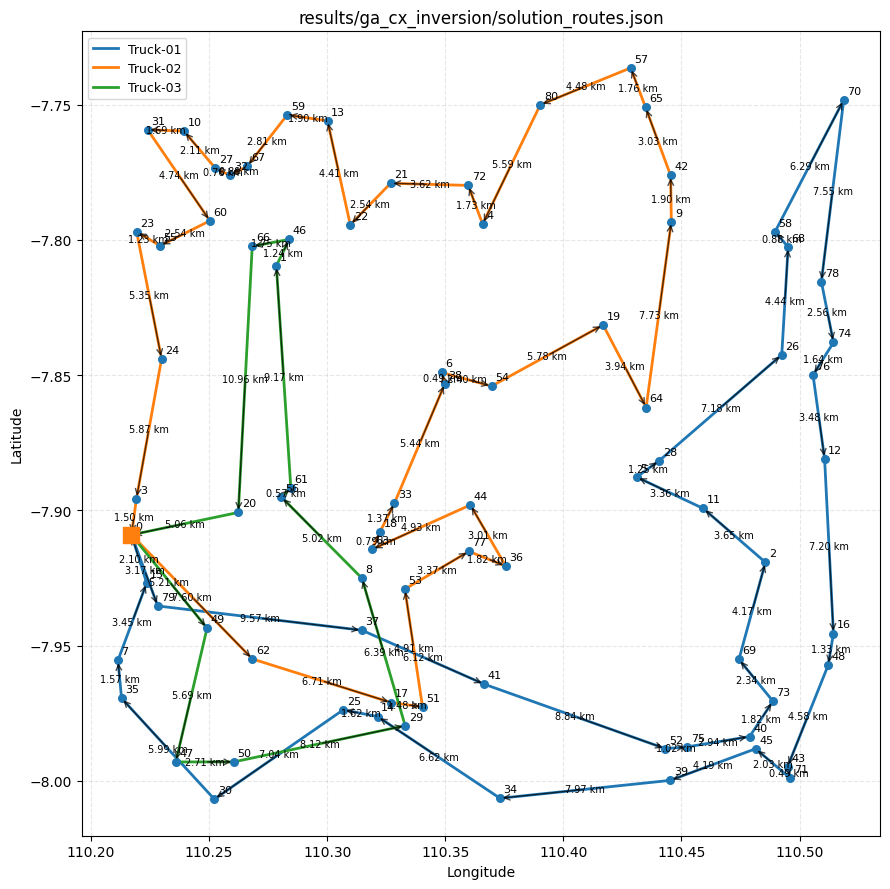

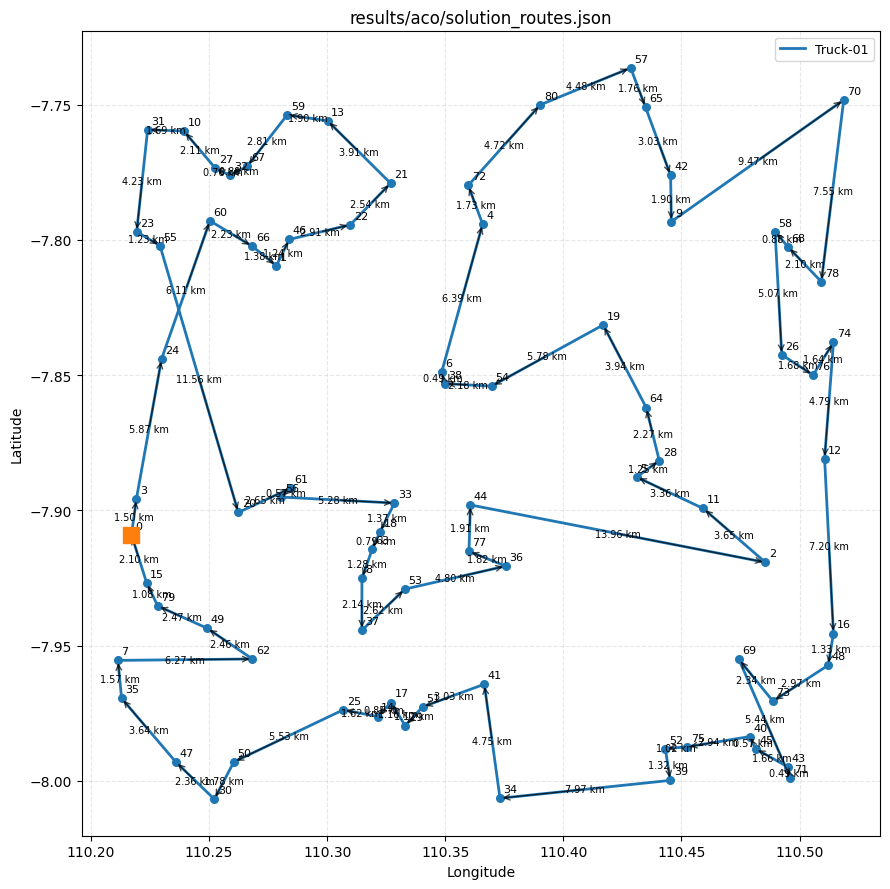

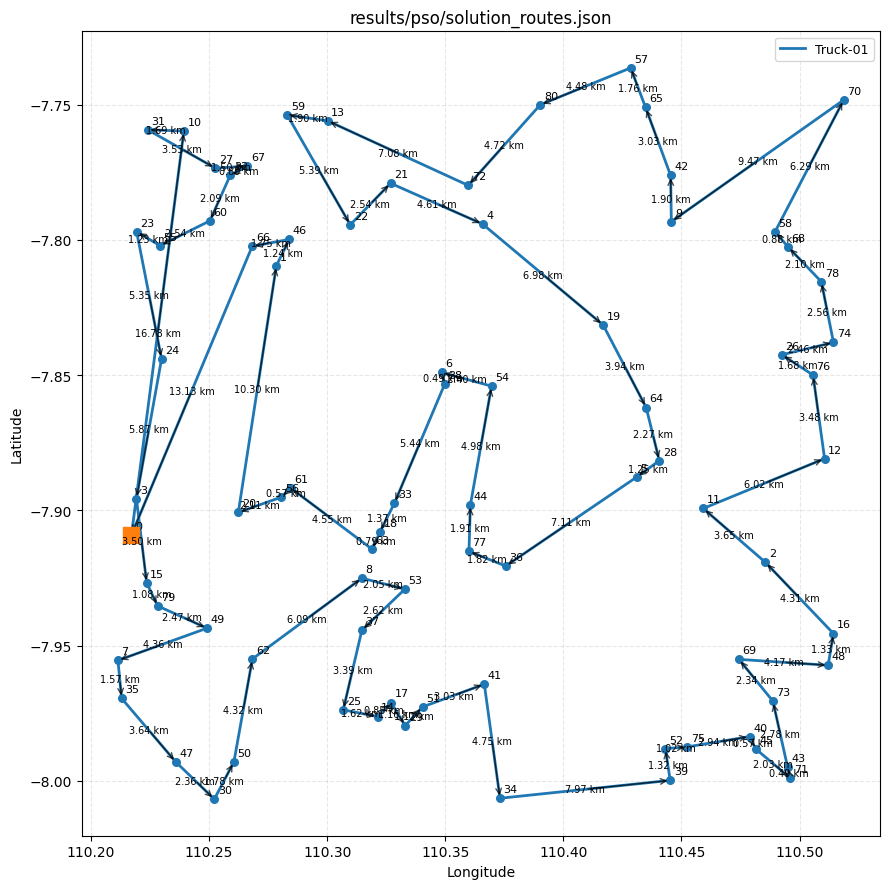

In [4]:
# Load nodes once
nodes_df, coords = load_nodes(nodes_filepath)

# Plot each solution file as a separate figure
for path in solution_routes_filepaths:
    sol = load_solution(path)
    ttl = title_from_path(path, use_basename_in_title)
    plot_solution(nodes_df, coords, sol, ttl)
